In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [5]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps=0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

In [6]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [7]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


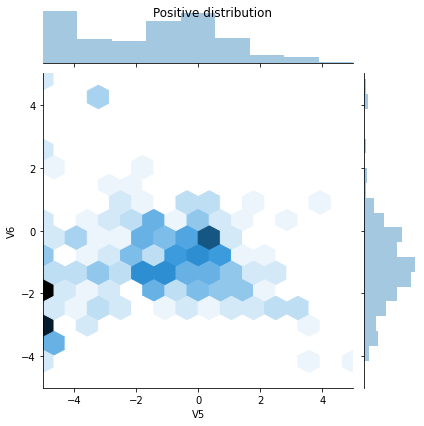

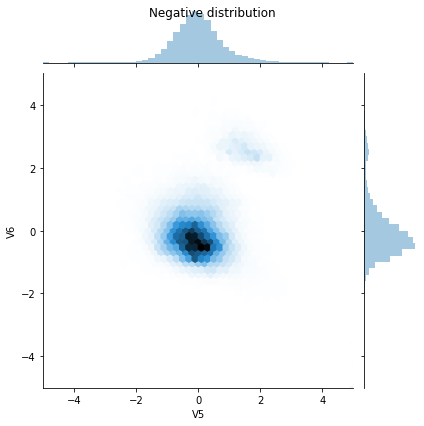

In [8]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")

In [9]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [10]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [11]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.predict(train_features[:10])

array([[0.870081  ],
       [0.93930435],
       [0.89731896],
       [0.8846406 ],
       [0.94873166],
       [0.943419  ],
       [0.84392726],
       [0.83281153],
       [0.8177836 ],
       [0.9213636 ]], dtype=float32)

In [13]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 2.1694


In [14]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [15]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.02358431],
       [0.00097477],
       [0.06622857],
       [0.01008794],
       [0.00091565],
       [0.00016344],
       [0.00181401],
       [0.00192431],
       [0.0014678 ],
       [0.00143016]], dtype=float32)

In [16]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0118


In [17]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [18]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [19]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [20]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

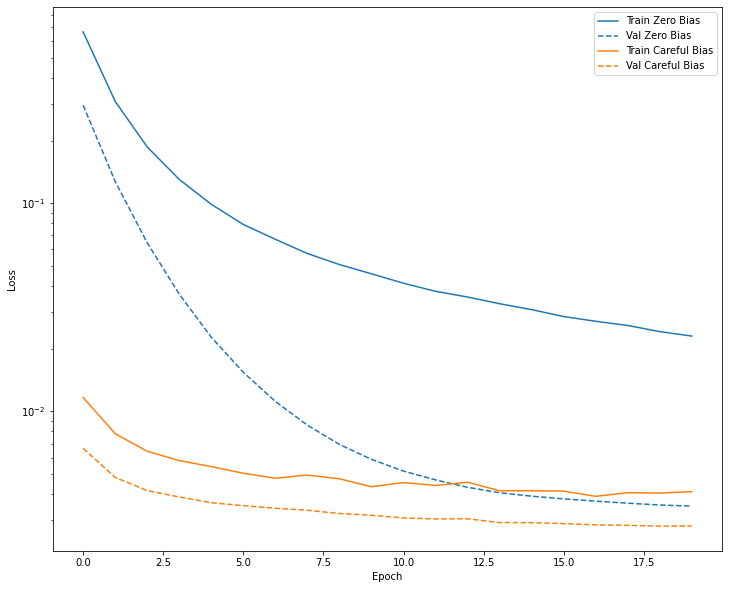

In [21]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [22]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 1s 11ms/step - loss: 0.0115 - tp: 115.0000 - fp: 77.0000 - tn: 227380.0000 - fn: 273.0000 - accuracy: 0.9985 - precision: 0.5990 - recall: 0.2964 - auc: 0.8085 - val_loss: 0.0066 - val_tp: 6.0000 - val_fp: 2.0000 - val_tn: 45482.0000 - val_fn: 79.0000 - val_accuracy: 0.9982 - val_precision: 0.7500 - val_recall: 0.0706 - val_auc: 0.9161
Epoch 2/100
90/90 [==============================] - 0s 5ms/step - loss: 0.0074 - tp: 115.0000 - fp: 34.0000 - tn: 181939.0000 - fn: 188.0000 - accuracy: 0.9988 - precision: 0.7718 - recall: 0.3795 - auc: 0.8429 - val_loss: 0.0048 - val_tp: 33.0000 - val_fp: 5.0000 - val_tn: 45479.0000 - val_fn: 52.0000 - val_accuracy: 0.9987 - val_precision: 0.8684 - val_recall: 0.3882 - val_auc: 0.9232
Epoch 3/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0063 - tp: 126.0000 - fp: 31.0000 - tn: 181942.0000 - fn: 177.0000 - accuracy: 0.9989 - precision: 0.8025 - recall: 0.4158 - auc: 0.8765 - val_

In [23]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


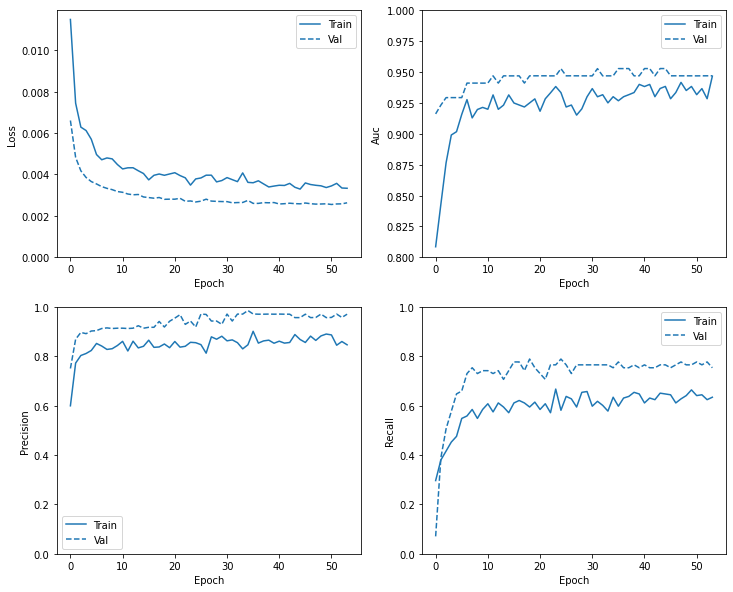

In [24]:
plot_metrics(baseline_history)

In [25]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [26]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.0037482203915715218
tp :  77.0
fp :  8.0
tn :  56850.0
fn :  27.0
accuracy :  0.9993855357170105
precision :  0.9058823585510254
recall :  0.7403846383094788
auc :  0.9227779507637024

Legitimate Transactions Detected (True Negatives):  56850
Legitimate Transactions Incorrectly Detected (False Positives):  8
Fraudulent Transactions Missed (False Negatives):  27
Fraudulent Transactions Detected (True Positives):  77
Total Fraudulent Transactions:  104


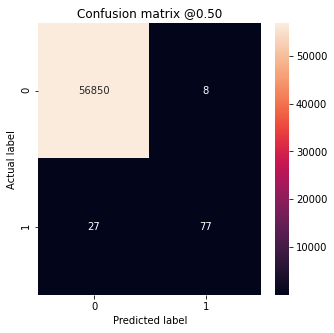

In [27]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [28]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

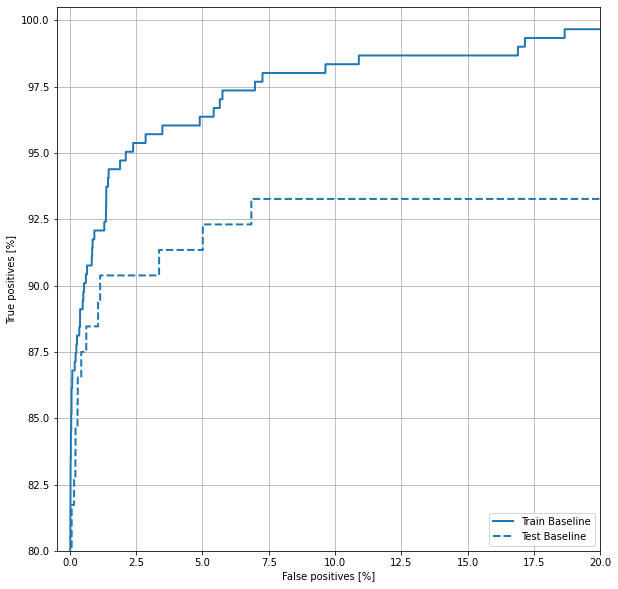

In [29]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [30]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [31]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
90/90 [==============================] - 1s 10ms/step - loss: 1.6353 - tp: 160.0000 - fp: 542.0000 - tn: 238289.0000 - fn: 247.0000 - accuracy: 0.9967 - precision: 0.2279 - recall: 0.3931 - auc: 0.8119 - val_loss: 0.0096 - val_tp: 44.0000 - val_fp: 17.0000 - val_tn: 45467.0000 - val_fn: 41.0000 - val_accuracy: 0.9987 - val_precision: 0.7213 - val_recall: 0.5176 - val_auc: 0.9555
Epoch 2/100
90/90 [==============================] - 0s 5ms/step - loss: 0.7935 - tp: 174.0000 - fp: 1154.0000 - tn: 180819.0000 - fn: 129.0000 - accuracy: 0.9930 - precision: 0.1310 - recall: 0.5743 - auc: 0.8918 - val_loss: 0.0138 - val_tp: 70.0000 - val_fp: 49.0000 - val_tn: 45435.0000 - val_fn: 15.0000 - val_accuracy: 0.9986 - val_precision: 0.5882 - val_recall: 0.8235 - val_auc: 0.9615
Epoch 3/100
90/90 [==============================] - 0s 5ms/step - loss: 0.5551 - tp: 216.0000 - fp: 2115.0000 - tn: 179858.0000 - fn: 87.0000 - accuracy: 0.9879 - precision: 0.0927 - recall: 0.7129 - auc: 0.9227

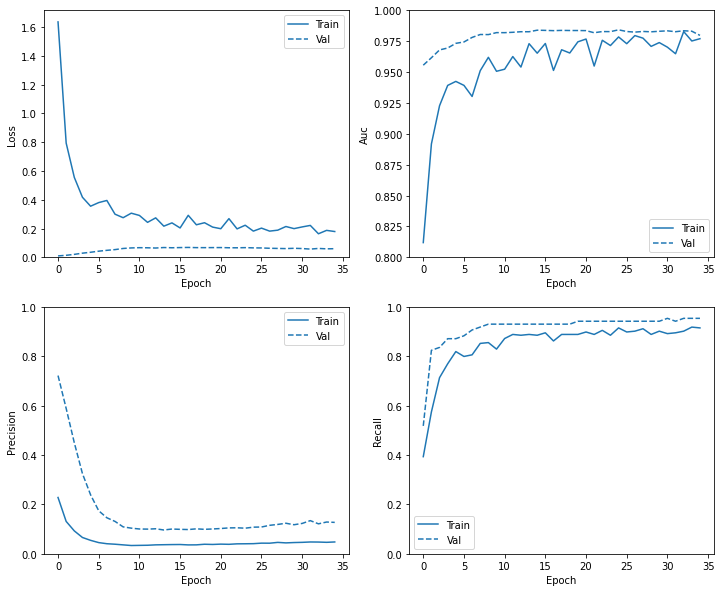

In [32]:
plot_metrics(weighted_history)

In [33]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.0699441060423851
tp :  91.0
fp :  859.0
tn :  55999.0
fn :  13.0
accuracy :  0.9846915602684021
precision :  0.09578947722911835
recall :  0.875
auc :  0.9675965309143066

Legitimate Transactions Detected (True Negatives):  55999
Legitimate Transactions Incorrectly Detected (False Positives):  859
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  91
Total Fraudulent Transactions:  104


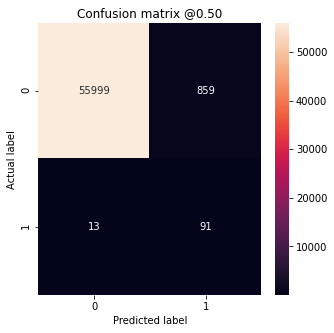

In [34]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

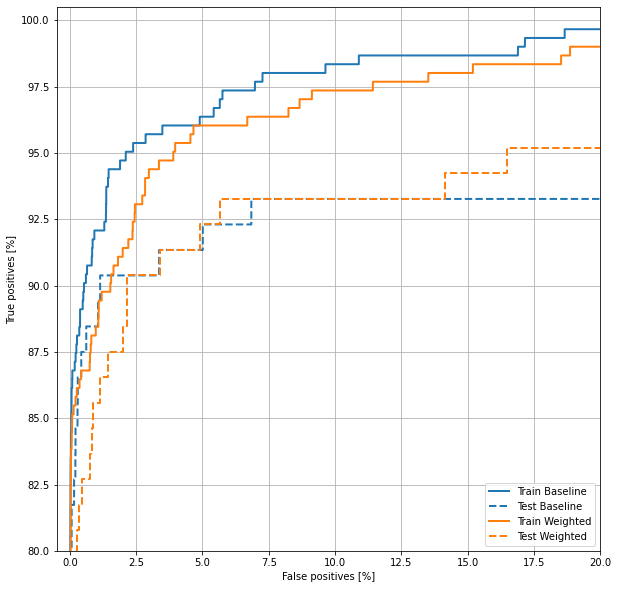

In [35]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

In [36]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [37]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181973, 29)

In [38]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363946, 29)

In [39]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [40]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 0.16094656  2.30540415 -3.69398021  4.26751083  1.10347436 -1.97117981
 -0.58881892  0.04634511 -2.44217835 -4.56350325  5.         -5.
  0.38731638 -5.         -1.48956586 -0.571933    0.92527427  1.78156886
 -2.22537455  0.50518089  0.28214798 -0.70543003 -0.94212154 -0.36068511
  2.83303803  1.01880078  1.28365676  1.24724811 -1.45226947]

Label:  1


In [41]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [42]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.51806640625


In [43]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

In [44]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 6s 23ms/step - loss: 0.3576 - tp: 248915.0000 - fp: 66718.0000 - tn: 274776.0000 - fn: 35897.0000 - accuracy: 0.8362 - precision: 0.7886 - recall: 0.8740 - auc: 0.9386 - val_loss: 0.1671 - val_tp: 80.0000 - val_fp: 1017.0000 - val_tn: 44467.0000 - val_fn: 5.0000 - val_accuracy: 0.9776 - val_precision: 0.0729 - val_recall: 0.9412 - val_auc: 0.9752
Epoch 2/100
278/278 [==============================] - 6s 21ms/step - loss: 0.1740 - tp: 260481.0000 - fp: 15697.0000 - tn: 269187.0000 - fn: 23979.0000 - accuracy: 0.9303 - precision: 0.9432 - recall: 0.9157 - auc: 0.9811 - val_loss: 0.0965 - val_tp: 81.0000 - val_fp: 883.0000 - val_tn: 44601.0000 - val_fn: 4.0000 - val_accuracy: 0.9805 - val_precision: 0.0840 - val_recall: 0.9529 - val_auc: 0.9801
Epoch 3/100
278/278 [==============================] - 6s 21ms/step - loss: 0.1363 - tp: 264686.0000 - fp: 10905.0000 - tn: 273522.0000 - fn: 20231.0000 - accuracy: 0.9453 - precision: 0.9604 -

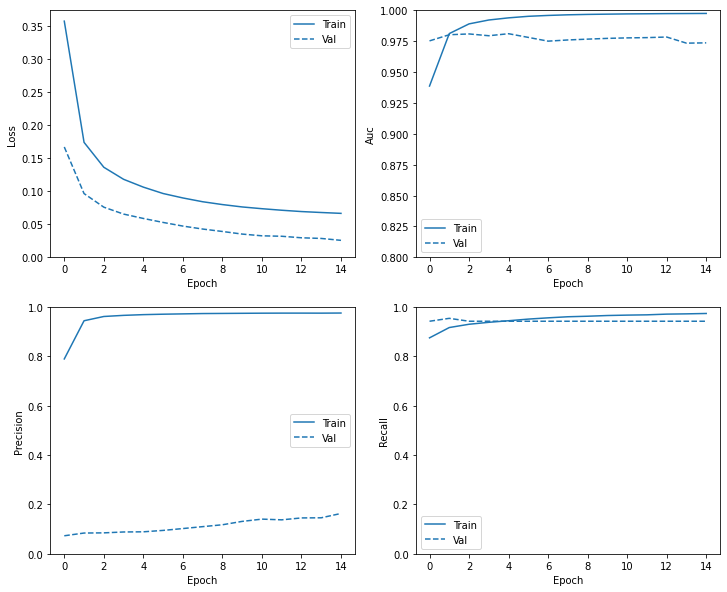

In [45]:
plot_metrics(resampled_history )

In [46]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 1s 49ms/step - loss: 0.7121 - tp: 14960.0000 - fp: 11164.0000 - tn: 54839.0000 - fn: 5566.0000 - accuracy: 0.8067 - precision: 0.5727 - recall: 0.7288 - auc: 0.9121 - val_loss: 0.7686 - val_tp: 82.0000 - val_fp: 21508.0000 - val_tn: 23976.0000 - val_fn: 3.0000 - val_accuracy: 0.5279 - val_precision: 0.0038 - val_recall: 0.9647 - val_auc: 0.9325
Epoch 2/1000
20/20 [==============================] - 1s 25ms/step - loss: 0.5771 - tp: 16772.0000 - fp: 9347.0000 - tn: 11172.0000 - fn: 3669.0000 - accuracy: 0.6822 - precision: 0.6421 - recall: 0.8205 - auc: 0.8256 - val_loss: 0.6444 - val_tp: 81.0000 - val_fp: 16336.0000 - val_tn: 29148.0000 - val_fn: 4.0000 - val_accuracy: 0.6414 - val_precision: 0.0049 - val_recall: 0.9529 - val_auc: 0.9474
Epoch 3/1000
20/20 [==============================] - 1s 26ms/step - loss: 0.4859 - tp: 17546.0000 - fp: 8019.0000 - tn: 12575.0000 - fn: 2820.0000 - accuracy: 0.7354 - precision: 0.6863 - recall: 0.

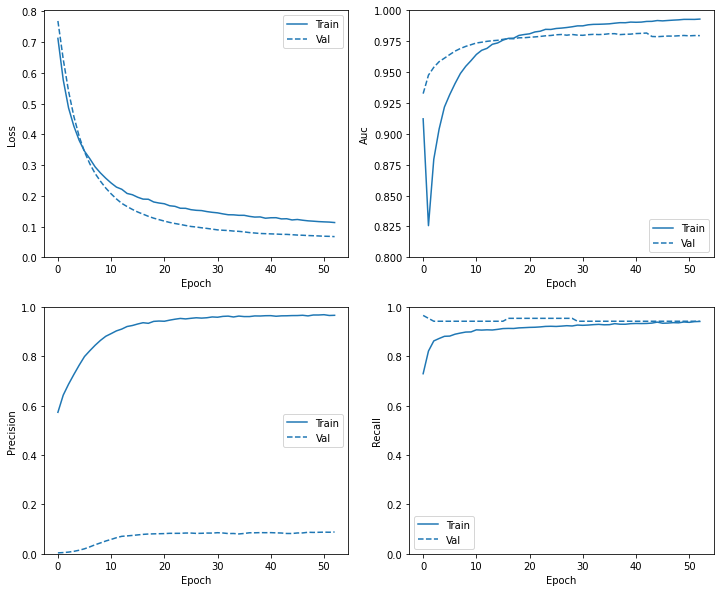

In [47]:
plot_metrics(resampled_history)

In [48]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.07604578137397766
tp :  92.0
fp :  1085.0
tn :  55773.0
fn :  12.0
accuracy :  0.980741560459137
precision :  0.07816482335329056
recall :  0.8846153616905212
auc :  0.9695630669593811

Legitimate Transactions Detected (True Negatives):  55773
Legitimate Transactions Incorrectly Detected (False Positives):  1085
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  92
Total Fraudulent Transactions:  104


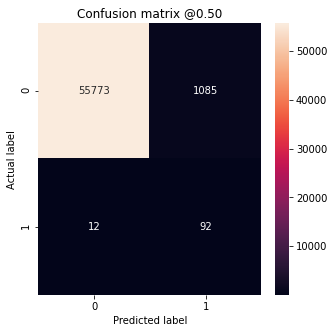

In [49]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

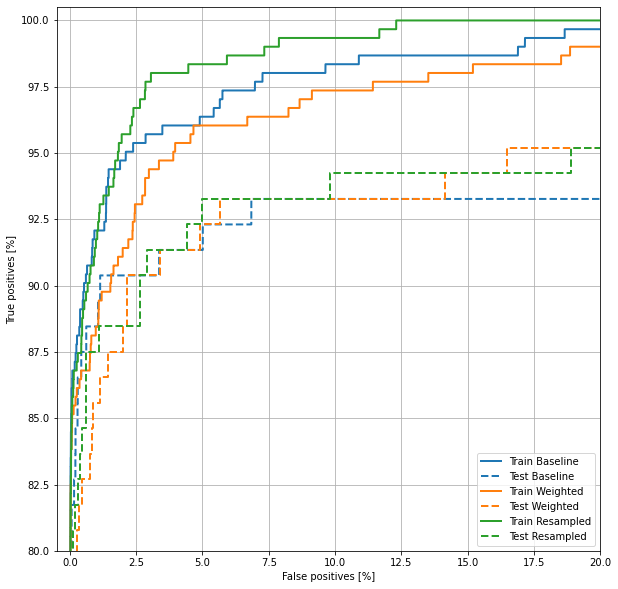

In [50]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')